In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#|default_exp gaussian_particle_system_genjax

In [3]:
#|export
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as Rot
from functools import partial
import genjax
from bayes3d.camera import Intrinsics, K_from_intrinsics, camera_rays_from_intrinsics
from bayes3d.transforms_3d import transform_from_pos_target_up, add_homogenous_ones, unproject_depth
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.math import lambertw


normal_cdf    = jax.scipy.stats.norm.cdf
normal_pdf    = jax.scipy.stats.norm.pdf
normal_logpdf = jax.scipy.stats.norm.logpdf
inv = jnp.linalg.inv
concat = jnp.concatenate

key = jax.random.PRNGKey(0)

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [4]:
#|export
from typing import Any, NamedTuple
import numpy as np
import jax
import jaxlib

Array = np.ndarray | jax.Array
Shape = int | tuple[int, ...]
Bool = Array
Float = Array
Int = Array

Pose = tuple[jnp.ndarray, jnp.ndarray]


class Pose(NamedTuple):
    quat: jnp.ndarray
    position: jnp.ndarray

In [5]:
def logit(x):
    return jnp.log(x/(1-x))

    
def pack_homogenous_matrix(x,q):
    r = Rot.from_quat(q).as_matrix()
    return concat([concat([r, x.reshape(-1,1)], axis=-1), jnp.array([[0.,0.,0.,1.]])])

In [6]:
def multiply_quaternions(q1, q2):

    w1, x1, y1, z1 = q1[3], q1[0], q1[1], q1[2]
    w2, x2, y2, z2 = q2[3], q2[0], q2[1], q2[2]

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2

    return jnp.array([x, y, z, w])

In [7]:
@genjax.Static
def motion_model(*args):
    q = genjax.normal(jnp.zeros(4), jnp.ones(4)) @ "q"
    q = q.at[3].set(1.0)
    q = q/jnp.linalg.norm(q)
    x = genjax.normal(jnp.zeros(3), jnp.ones(3)) @ "x"
    return pack_homogenous_matrix(x,q)


@genjax.Static
def coordinate_frame_prior(Q):
    q = genjax.normal(jnp.zeros(4), jnp.ones(4)) @ "q"
    q = q.at[3].set(1.0)
    q = q/jnp.linalg.norm(q)
    x = genjax.normal(jnp.zeros(3), jnp.ones(3)) @ "x"
    return Q@pack_homogenous_matrix(x,q)

In [8]:
key = keysplit(key)
tr = motion_model.simulate(key,())
Q = tr.retval
print(Q)
tr = coordinate_frame_prior.simulate(key,(Q,))
print(tr.retval)

[[-0.21356526 -0.22192055 -0.9513892  -1.8099072 ]
 [ 0.97607225 -0.00769535 -0.217311    0.40000528]
 [ 0.04090449 -0.9750345   0.21825388 -0.88583   ]
 [ 0.          0.          0.          1.        ]]
[[-0.20991647  0.9767395   0.04376509 -0.6693742 ]
 [-0.22485533 -0.00466556 -0.97438127 -1.1771727 ]
 [-0.9515123  -0.21437937  0.22060438 -1.5432181 ]
 [ 0.          0.          0.          1.        ]]


In [9]:
class GaussianParticleSystem(NamedTuple):
    mus: Array
    covariances: Array
    colors: Array

class HierachicalGaussianParticleSystem(NamedTuple):
    particles:  GaussianParticleSystem
    coordinate_frames: Array
    assignments: Array
    max_systems: Array

In [10]:
banana = jnp.load("data/gaussians_examples/gaussians_banana_150.npz")
scissors = jnp.load("data/gaussians_examples/gaussians_scissors_550.npz")

mus  = concat([banana["mus"],scissors["mus"]])
covs = concat([banana["covs"],scissors["covs"]])
embs = concat([banana["choleskys"],scissors["choleskys"]])
cols = concat([banana["mean_colors"],scissors["mean_colors"]])
# zs   = concat([jnp.zeros(150),jnp.ones(550)])
zs = jnp.zeros(mus.shape[0])

Qs = jnp.tile(jnp.eye(4,4), (10,1,1))
Qs.shape

(10, 4, 4)

In [11]:
hgps = HierachicalGaussianParticleSystem(
    particles = GaussianParticleSystem(mus, covs, cols),
    coordinate_frames=Qs,
    assignments=zs,
    max_systems= jnp.array([10])
)

In [12]:
def make_constant_model(x):

    @genjax.Static
    def constant_model(*args):
        _ = genjax.bernoulli(jnp.inf) @ "void"
        return x
        
    return constant_model

In [13]:
def replacer(v, a, b):
    i = jnp.searchsorted(a, v)
    return b[i]


In [14]:
const_zero = make_constant_model(jnp.array(0.0))
args = (0,2)
const_zero.simulate(key, args).get_retval(), genjax.uniform.simulate(key, args).get_retval()

(Array(0., dtype=float32, weak_type=True), Array(0.16124868, dtype=float32))

In [15]:
genjax.Switch(genjax.uniform, genjax.uniform).simulate(key, (0, 0.,1.)).get_retval()

Array(0.08062434, dtype=float32)

In [16]:
split_decisions = jnp.array([1,1,0])

key = keysplit(key)
genjax.Map(genjax.Switch(const_zero, genjax.uniform), in_axes=(0,0,0)).simulate(key, (
                                split_decisions, 
                                -jnp.ones(3), jnp.ones(3)
)).get_retval()

Array([-0.6285095 ,  0.73567224,  0.        ], dtype=float32)

## Particle system prior

In [18]:
@genjax.Static
def gaussian_embedding_prior(size_bounds):
    emb = genjax.uniform(*jnp.tile(size_bounds, (1, 3, 3))) @ "embedding_matrix"
    return emb

In [19]:
def make_gaussian_particle_system_prior(max_particles: int):

    @genjax.Static
    def gaussian_embedding_prior(size_bounds):
        """Samples and embedding matrix."""
        emb = genjax.uniform(*jnp.tile(size_bounds, (1, 3,3))) @ "embedding_matrix"
        return emb


    @genjax.Static
    def gaussian_particle_system_prior(particle_bounds, embedding_bounds):
        """Naive prior over Gaussian particle systems."""

        N = genjax.categorical(jnp.ones(max_particles)) @ "N" 
        particle_mask = jnp.arange(max_particles) < N
        mus = genjax.Map(genjax.uniform, in_axes=(0,))(
                    jnp.tile(particle_bounds, (max_particles,1,1))) @ "centers"
        embs = genjax.Map(gaussian_embedding_prior, in_axes=(0,))(
                    jnp.tile(embedding_bounds, (max_particles,1))) @ "embedding_matrices"
        cols = genjax.Map(genjax.uniform, in_axes=(0,0))(
                    jnp.zeros((max_particles, 3)), jnp.ones((max_particles, 3))) @ "colors"
        alphas = genjax.Map(genjax.uniform, in_axes=(0,0))(
                    jnp.zeros(max_particles), jnp.ones(max_particles)) @ "transparencies"

        return mus, embs, cols, alphas, particle_mask


    return gaussian_particle_system_prior


In [21]:
key = keysplit(key)
max_particles = 20

particle_bounds  = jnp.array([[0.,0.,0.],[1.,1.,1.]])
embedding_bounds = jnp.array([-5., 5.]) 
maker_args = (max_particles,)
model_args = (
    particle_bounds,
    embedding_bounds
)
model = make_gaussian_particle_system_prior(*maker_args)
tr = model.simulate(key, model_args)

mus, embs, cols, alphas, particle_mask = tr.get_retval()

## Split clustering model

### Model structure
- Should the structure rather be, decision to potentially split (or re-evalutate) and then re-cluster? This is more like make a decision first and then spend the time and compute to re-cluster. 
- Or is at each time re-cluster everything basically?
- We could make re-evaluation decisions more general, ie., pick a subset of clusters and re-evaluate their structure.


```python
cluster_splits = jnp.arange(max_clusters+1).at[split_ids].set(free_ids)[:-1]
```

In [102]:
def make_split_model(max_cluster):

    
    const_eye  = make_constant_model(jnp.eye(4))
    const_zero = make_constant_model(jnp.array(0.0))


    @genjax.Static
    def split_model(state, particle_mask, split_probs):
        """Splits clusters and migrates particles to new clusters."""
        t, zs, Qs = state


        slots_taken = jnp.isin(jnp.arange(max_clusters), zs)
        slots_free  = slots_taken == False
        free_ids    = jnp.nonzero(slots_free , size=max_clusters, fill_value=max_clusters-1)[0]

        # -----------------------
        # Split clusters
        # -----------------------
        # TODO: genjax's masked combinator?
        # TODO: Make sure enough free ids are available, ie., 
        #   ensure that `sum(split_decisions) < sum(slots_free)`
        # TODO: What if we allow to split into more than 2 clusters? Ask Ben.
        split_probs *= slots_taken
        split_decisions = genjax.bernoulli(
                            logit(split_probs)) @ "split_decisions"

        # The first sum(split_decisions) indices contain the 
        # ids of clusters that spun out new clusters
        split_ids   = jnp.nonzero(split_decisions, size=max_clusters, fill_value=max_clusters-1)[0]
        spinoff_ids = jnp.where(split_ids != max_clusters-1, free_ids, max_clusters-1)

        # ----------------------------------------------------
        # Re-cluster/Migrate particles 
        # from old clusters to new clusters
        # ----------------------------------------------------
        # TODO: genjax's masked combinator?
        # TODO: Replace by a dirichlet distribution
        cluster_probs = genjax.Map(genjax.Switch(const_zero, genjax.uniform), in_axes=(0,0,0))(
                                split_decisions.astype(jnp.int32), 
                                jnp.zeros(max_clusters), jnp.ones(max_clusters)
                            )  @ "cluster_probs"

        migration_probs     = cluster_probs[zs]
        migration_decisions = genjax.Map(genjax.bernoulli, in_axes=(0,))(
                                logit(migration_probs)) @ "migration_decisions"

        zs_new = jnp.where(migration_decisions, 
                    vmap(lambda z: spinoff_ids[jnp.searchsorted(split_ids, z)])(zs),
                    zs)

        # -------------------------------
        # Create poses for new clusters
        # -------------------------------
        # TODO: genjax's masked combinator?
        switcher = genjax.Switch(const_eye, coordinate_frame_prior)
        Qs_spinoff = genjax.Map(switcher, in_axes=(0,0))(
                            split_decisions.astype(jnp.int32), Qs) @ "split_poses"
                            
        Qs_new = jnp.where(jnp.isin(jnp.arange(max_clusters), spinoff_ids)[:,None,None], Qs_spinoff, Qs)

        # -----------------------
        # Dynamics
        # -----------------------
        dQs = genjax.Map(motion_model, in_axes=(0,))(Qs_new) @ "motion_updates"
        Qs_new = Qs_new @ dQs

        return (t+1, zs_new, Qs_new)

    return split_model

(20, 4, 4)
1


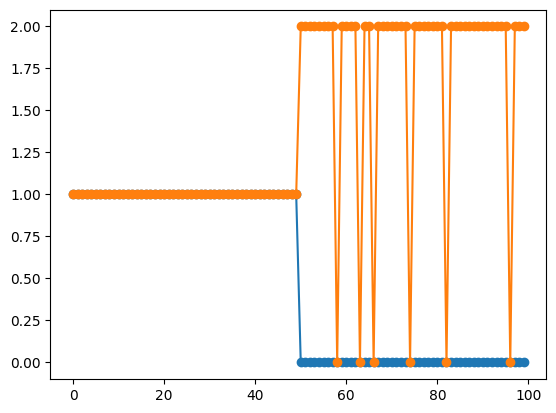

In [49]:
key = keysplit(key)
max_clusters  = 20
num_particles = 100
zs = jnp.zeros(num_particles).astype(jnp.int32)
zs = zs.at[:50].set(1)
Qs = jnp.tile(jnp.eye(4,4), (max_clusters,1,1))
split_probs = jnp.ones(max_clusters)*0.5

model  = make_split_model(max_clusters)
tr = model.simulate(key, (zs, jnp.ones(num_particles),  Qs, split_probs));


zs_, Qs_, (split_probs, slots_taken, split_decisions) = tr.retval

print(Qs_.shape)

print(split_decisions.sum())
plt.plot(zs, marker="o")
plt.plot(zs_, marker="o")


In [155]:
def make_hierarchical_gaussian_particle_model(max_clusters, max_particles):
    
    
    split_model = make_split_model(max_clusters)
    split_chain = genjax.Unfold(split_model, 10)

    gaussian_particle_system_prior = make_gaussian_particle_system_prior(max_particles)

    @genjax.Static
    def hierarchical_gaussian_particle_model(T, particle_bounds, embedding_bounds, split_probs):

        mus, embs, cols, alphas, particle_mask = gaussian_particle_system_prior(particle_bounds, embedding_bounds) @ "particles"

        # # TODO: genjax's masked combinator?
        zs = genjax.Map(genjax.categorical, in_axes=(0,))(
                        jnp.tile(jnp.ones(max_clusters), (max_particles, 1) ) ) @ "initial_assignments"
        Qs = genjax.Map(coordinate_frame_prior, in_axes=(0,))(
                        jnp.tile(jnp.eye(4,4), (max_clusters,1,1))) @ "initial_coordinate_frames"


        chain = split_chain(T, (0, zs, Qs), particle_mask, split_probs) @ "split_chain"

        return zs, Qs, chain
        

    return hierarchical_gaussian_particle_model

In [157]:

max_clusters  = 10
max_particles = 100 
particle_bounds  = jnp.array([[0.,0.,0.],[1.,1.,1.]])
embedding_bounds = jnp.array([-5., 5.]) 
split_probs = jnp.ones(max_clusters)*0.5


model = make_hierarchical_gaussian_particle_model(max_clusters, max_particles)
tr,w = model.importance(key, 
genjax.choice_map({
    "initial_assignments": genjax.vector_choice_map(genjax.choice_value(jnp.zeros(max_particles).astype(jnp.int32)))
}),
(10, particle_bounds, embedding_bounds, split_probs))


In [158]:
zs0, Qs0, (ts, zs, qs) = tr.retval
ts.shape, zs.shape, qs.shape

((10,), (10, 100), (10, 10, 4, 4))

In [162]:
zs0.shape

(100,)

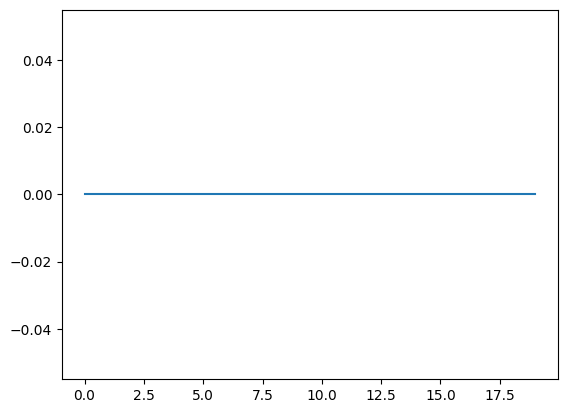

In [161]:
plt.plot(zs0[:20])
# plt.plot(zs[:,:20])